In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import io

plt.rcParams.update({
    'font.size': 30,  # Base font size
    'axes.titlesize': 30,  # Title font size
    'axes.labelsize': 30,  # Axis label font size
    'xtick.labelsize': 25,  # X-axis tick labels
    'ytick.labelsize': 25,  # Y-axis tick labels
    'legend.fontsize': 25,  # Legend font size
    'figure.titlesize': 30  # Figure title size
})

In [3]:
# --- Data Preparation ---
# Use the same data as the previous example

csv_data = """
TestName,Ns,Nw,Ny,Nx,WallTime,CpuTime
fftw, 1, 1, 1000, 1000, 0.006837, 1048228.00
fftw, 1, 10, 1000, 1000, 0.008077, 2468732.00
fftw, 1, 100, 1000, 1000, 0.067130,	21800350.00
fftw, 1, 1000, 1000, 1000, 0.896099,	21800350.00
fftw, 1, 1250, 1000, 1000, 0.973578,	21800350.00
fftw, 1, 1500, 1000, 1000, 0.923556,	21800350.00
cuFFT + copy, 1, 1, 1000, 1000,  0.004063 ,	91281926.00
cuFFT + copy, 1, 10, 1000, 1000,  0.032689,	1133094472.00
cuFFT + copy, 1, 100, 1000, 1000, 0.270400 ,	11413964558.00
cuFFT + copy, 1, 1000, 1000, 1000, 2.434551 ,	11413964558.00
cuFFT + copy, 1, 1250, 1000, 1000, 3.313732 ,	11413964558.00
cuFFT + copy, 1, 1500, 1000, 1000, 3.877401 ,	11413964558.00
cuFFT, 1, 1, 1000, 1000, 0.000079,	17000.00
cuFFT, 1, 10, 1000, 1000, 0.000607,	17710.00
cuFFT, 1, 100, 1000, 1000, 0.005518,	17502.00
cuFFT, 1, 1000, 1000, 1000, 0.054848,	17502.00
cuFFT, 1, 1250, 1000, 1000, 0.068548,	17502.00
cuFFT, 1, 1500, 1000, 1000, 0.082228,	17502.00
"""



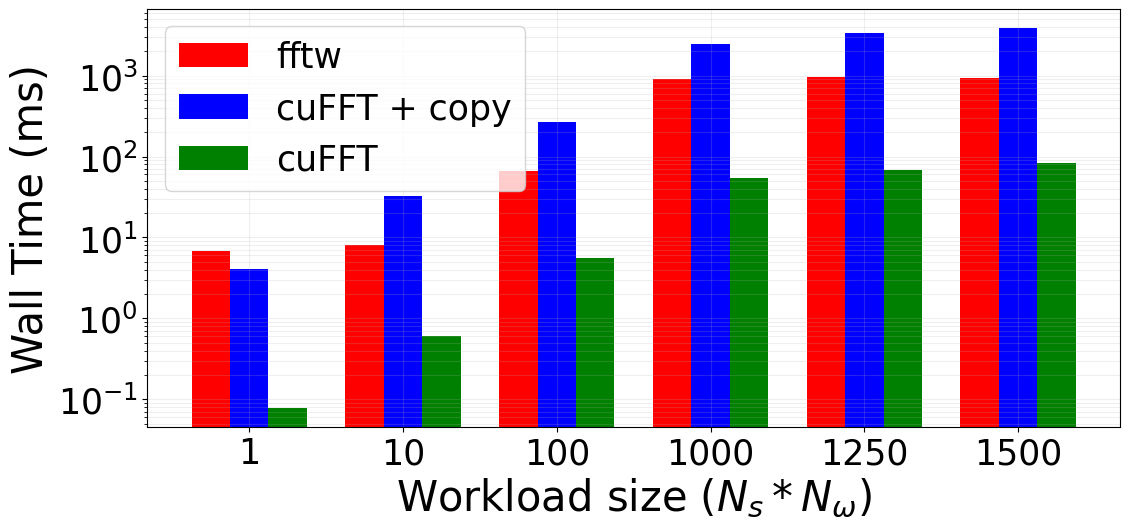

In [4]:


# Parse the CSV data
data = pd.read_csv(io.StringIO(csv_data))

# Create a new column for Ns*Nw
data['Ns_Nw'] = data['Ns'] * data['Nw']

# Convert WallTime to milliseconds for better readability
data['WallTime_ms'] = data['WallTime'] * 1000

# Create the bar plot
plt.figure(figsize=(12, 6))

# Get unique values of Ns*Nw for x-axis
x_values = sorted(data['Ns_Nw'].unique())
x_positions = range(len(x_values))
width = 0.25  # Width of bars

# Plot bars for each test type
cpu_data = data[data['TestName'] == 'fftw']
gpu_host_data = data[data['TestName'] == 'cuFFT + copy']
gpu_device_data = data[data['TestName'] == 'cuFFT']

plt.bar([p - width for p in x_positions], cpu_data['WallTime_ms'], width, label='fftw', color='red')
plt.bar(x_positions, gpu_host_data['WallTime_ms'], width, label='cuFFT + copy', color='blue')
plt.bar([p + width for p in x_positions], gpu_device_data['WallTime_ms'], width, label='cuFFT', color='green')

# Add labels$ and title
plt.xlabel(r'Workload size ($N_s * N_\omega$)')
plt.ylabel('Wall Time (ms)')
plt.xticks(x_positions, x_values)
plt.legend()

# Using log scale because of the large differences in values
plt.yscale('log')
plt.grid(True, which="both", ls="-", alpha=0.2)

plt.tight_layout()

plt.savefig('fft_times.png', dpi=300, bbox_inches='tight')

plt.show()



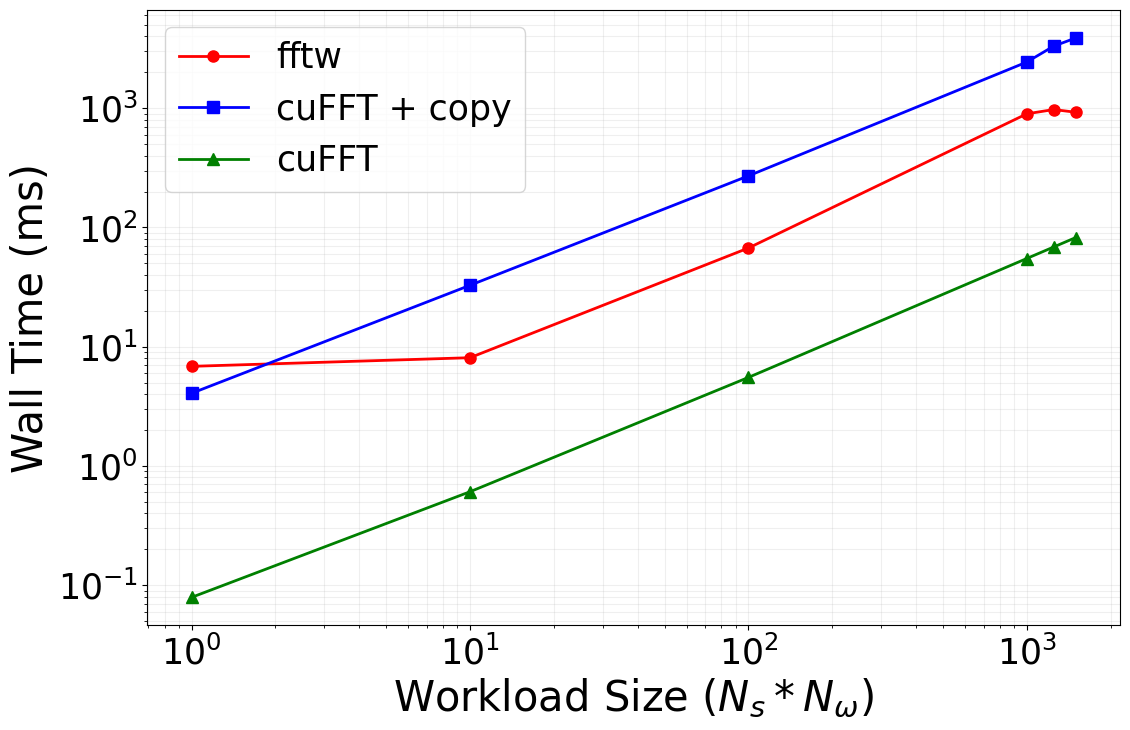

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io

# Set up the figure
plt.figure(figsize=(12, 8))

# Plot the curves
plt.plot(cpu_data['Ns_Nw'], cpu_data['WallTime_ms'], 'o-', color='red', linewidth=2, markersize=8, label='fftw')
plt.plot(gpu_host_data['Ns_Nw'], gpu_host_data['WallTime_ms'], 's-', color='blue', linewidth=2, markersize=8, label='cuFFT + copy')
plt.plot(gpu_device_data['Ns_Nw'], gpu_device_data['WallTime_ms'], '^-', color='green', linewidth=2, markersize=8, label='cuFFT')

# Set log scales for both axes to better visualize the scaling behavior
plt.xscale('log')
plt.yscale('log')

# Add grid lines
plt.grid(True, which="both", ls="-", alpha=0.2)

# Add labels and title
plt.xlabel(r'Workload Size ($N_s * N_\omega$)')
plt.ylabel('Wall Time (ms)')

# Add legend
plt.legend()

plt.tight_layout()

plt.savefig('fft_scaling.png', dpi=300, bbox_inches='tight')

plt.show()

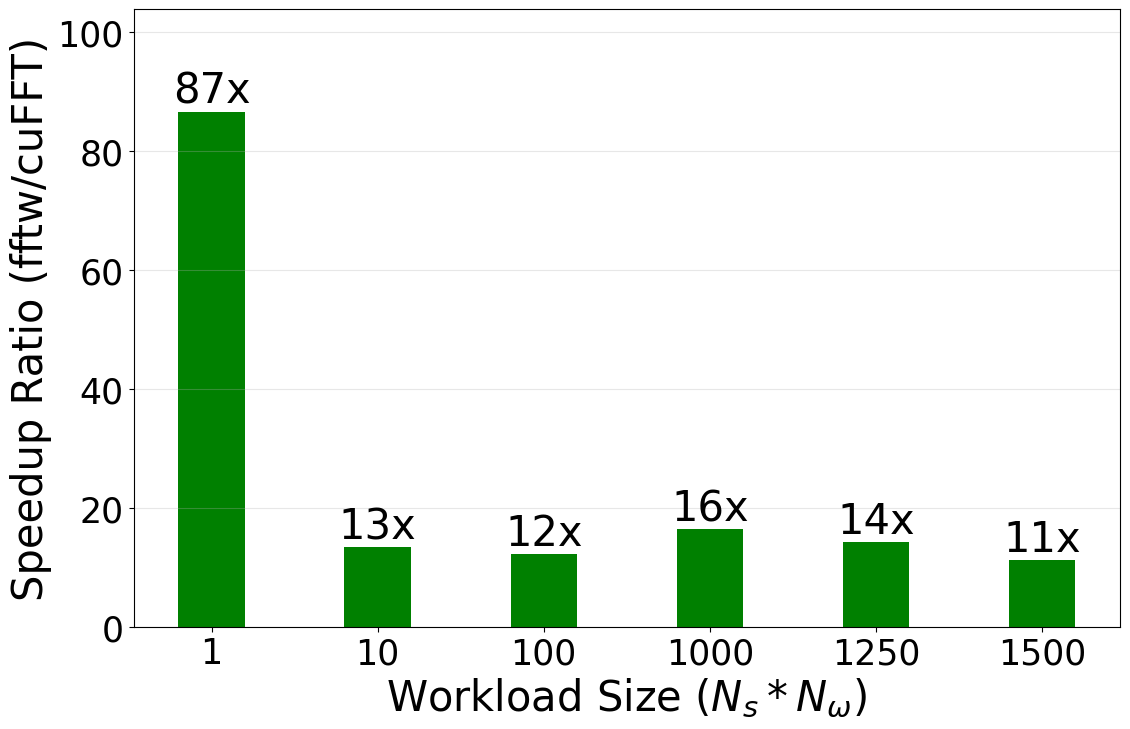

In [9]:
# Create a DataFrame for the speedup calculation
speedup_df = pd.DataFrame({
    'Ns_Nw': cpu_data['Ns_Nw'].values,
    'CPU_Time': cpu_data['WallTime_ms'].values,
    'GPU_Device_Time': gpu_device_data['WallTime_ms'].values
})

# Calculate speedup (CPU time / GPU Device time)
speedup_df['Speedup'] = speedup_df['CPU_Time'] / speedup_df['GPU_Device_Time']

# Create a figure with two subplots
plt.figure(figsize=(12, 8))

# Plot 2: Speedup ratio (CPU/GPU Device)
bars = plt.bar(speedup_df['Ns_Nw'].astype(str), speedup_df['Speedup'], color='green', width=0.4)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.0f}x', ha='center', va='bottom')

# Customize the speedup plot
plt.xlabel(r'Workload Size ($N_s * N_\omega$)')
plt.ylabel('Speedup Ratio (fftw/cuFFT)')
plt.grid(axis='y', alpha=0.3)
plt.ylim(bottom=0, top=speedup_df['Speedup'].max() * 1.2)  # Add 20% headroom

plt.tight_layout()

plt.savefig('fft_speedup.png', dpi=300, bbox_inches='tight')

plt.show()

In [44]:

csv_data = """
TestName,Ns,Nw,WallTime
1,1,1,	143913
1,1,10,	44611
1,1,100,	45729
5,1,1,	133017
5,1,10,	150203
5,1,100,	111695
10,1,1,	291920
10,1,10,	258595
10,1,100,	197320
20,1,1,	723650
20,1,10,	557189
20,1,100,	467684
50,1,1,	1594590
50,1,10,	1166162
50,1,100,	1019142
"""

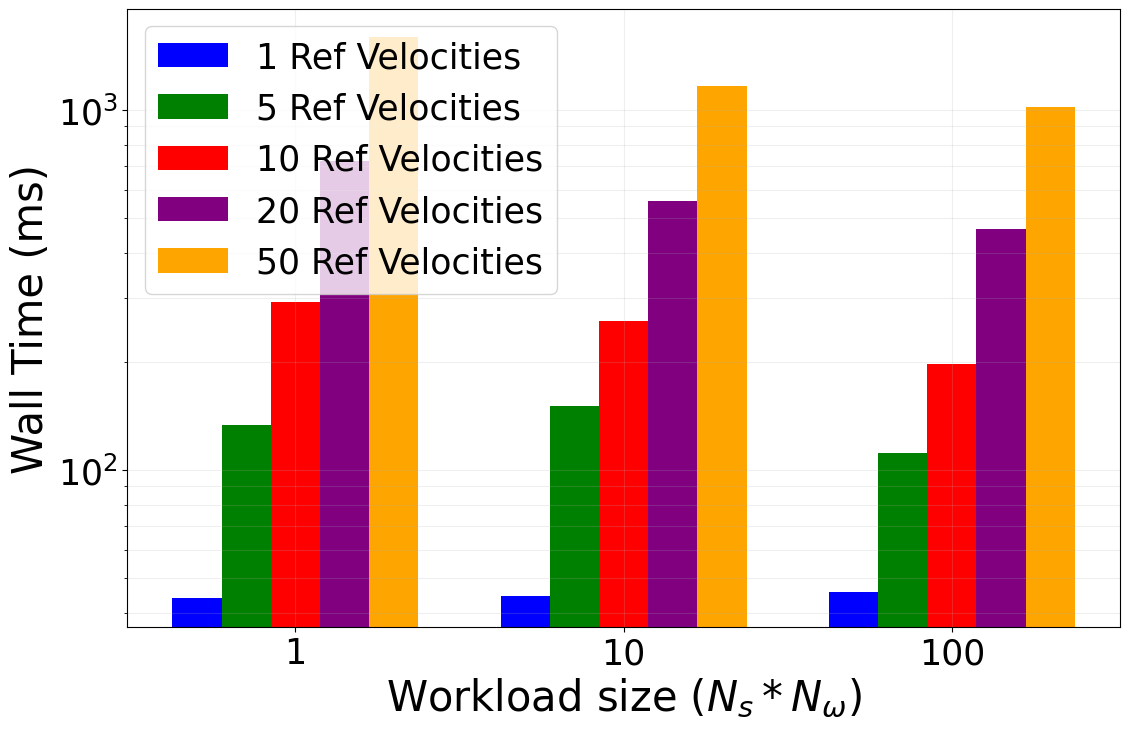

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io

# Parse the CSV data
csv_data = """
TestName,Ns,Nw,WallTime
1,1,1,43913
1,1,10,44611
1,1,100,45729
5,1,1,133017
5,1,10,150203
5,1,100,111695
10,1,1,291920
10,1,10,258595
10,1,100,197320
20,1,1,723650
20,1,10,557189
20,1,100,467684
50,1,1,1594590
50,1,10,1166162
50,1,100,1019142
"""

data = pd.read_csv(io.StringIO(csv_data))

# Create a new column for Ns*Nw
data['Ns_Nw'] = data['Ns'] * data['Nw']

# Convert WallTime to milliseconds for better readability
data['WallTime_ms'] = data['WallTime'] / 1000

# Create the bar plot
plt.figure(figsize=(12, 8))

# Get unique values of Ns*Nw for x-axis and TestName for grouping
workloads = sorted(data['Nw'].unique())
ref_velocities = sorted(data['TestName'].unique())

# Set positions and width
x_positions = np.arange(len(workloads))
width = 0.15  # Width of bars (narrower because we have more bars)
colors = ['blue', 'green', 'red', 'purple', 'orange']

# Plot bars for each reference velocity
for i, vel in enumerate(ref_velocities):
    vel_data = data[data['TestName'] == vel]
    # Create a dictionary mapping Nw to WallTime_ms for easier lookup
    time_dict = dict(zip(vel_data['Nw'], vel_data['WallTime_ms']))
    # Ensure all workloads are included, using 0 for missing values
    heights = [time_dict.get(nw, 0) for nw in workloads]
    
    position = x_positions + (i - len(ref_velocities)/2 + 0.5) * width
    plt.bar(position, heights, width, 
            label=f'{vel} Ref Velocities', 
            color=colors[i % len(colors)])

# Add labels and title
plt.xlabel(r'Workload size ($N_s * N_\omega$)')
plt.ylabel('Wall Time (ms)')
plt.xticks(x_positions, workloads)
plt.legend()

# Using log scale because of the large differences in values
plt.yscale('log')
plt.grid(True, which="both", ls="-", alpha=0.2)

# Add grid lines and clean up
plt.tight_layout()

# Save the figure
plt.savefig('pspi_times.png', dpi=300, bbox_inches='tight')

plt.show()

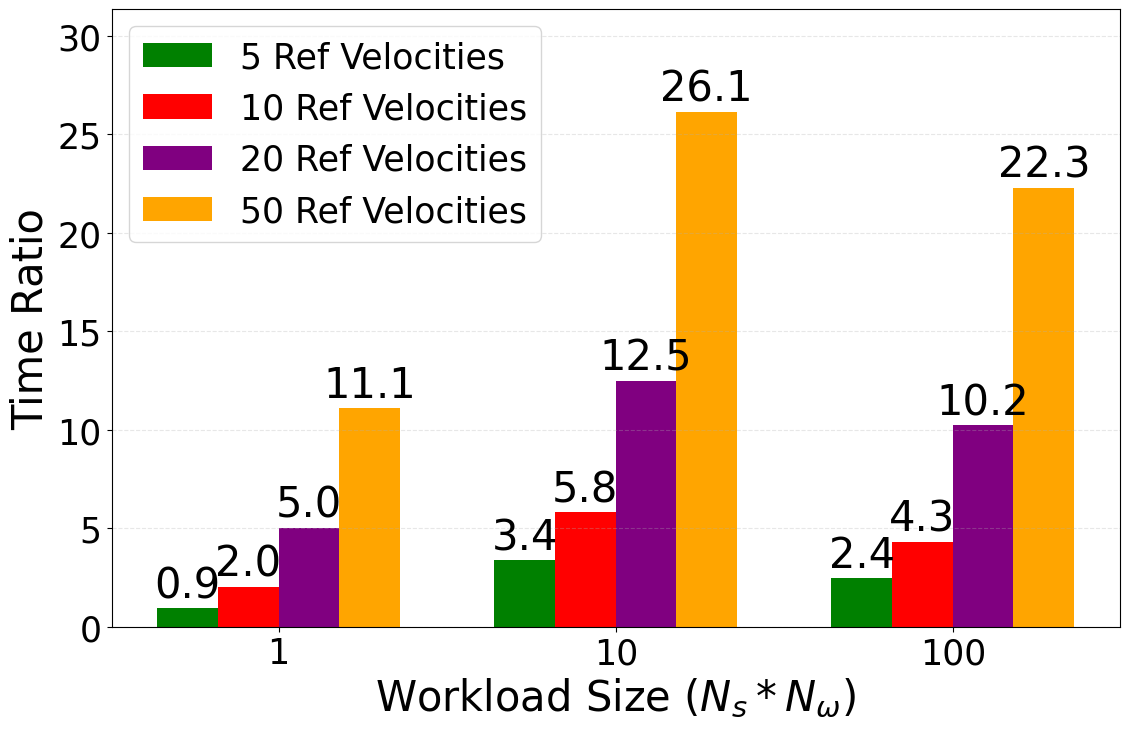

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io

# Parse the CSV data
csv_data = """
TestName,Ns,Nw,WallTime
1,1,1,143913
1,1,10,44611
1,1,100,45729
5,1,1,133017
5,1,10,150203
5,1,100,111695
10,1,1,291920
10,1,10,258595
10,1,100,197320
20,1,1,723650
20,1,10,557189
20,1,100,467684
50,1,1,1594590
50,1,10,1166162
50,1,100,1019142
"""

data = pd.read_csv(io.StringIO(csv_data))

# Convert WallTime to milliseconds for better readability
data['WallTime_ms'] = data['WallTime'] / 1000

# Create a pivot table for easier ratio calculation
pivot_data = data.pivot_table(index='Nw', columns='TestName', values='WallTime_ms')

# Calculate ratios relative to reference velocity = 1
for col in pivot_data.columns:
    if col != 1:  # Skip the baseline column
        pivot_data[f'Ratio_{col}_to_1'] = pivot_data[col] / pivot_data[1]

# Create the bar plot for ratios
plt.figure(figsize=(12, 8))

# Get workload values and reference velocities
workloads = sorted(data['Nw'].unique())
ref_velocities = sorted([col for col in pivot_data.columns if isinstance(col, int) and col != 1])

# Set positions and width
x_positions = np.arange(len(workloads))
width = 0.18  # Width of bars
colors = ['green', 'red', 'purple', 'orange']

# Plot bars for each reference velocity ratio
for i, vel in enumerate(ref_velocities):
    ratios = pivot_data[f'Ratio_{vel}_to_1']
    position = x_positions + (i - len(ref_velocities)/2 + 0.5) * width
    bars = plt.bar(position, ratios, width, 
            label=f'{vel} Ref Velocities', 
            color=colors[i % len(colors)])
    
    # Add ratio values on top of bars
    for bar, ratio in zip(bars, ratios):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{ratio:.1f}', ha='center', va='bottom')

# Add labels and title
plt.xlabel(r'Workload Size ($N_s * N_\omega$)')
plt.ylabel('Time Ratio')
plt.xticks(x_positions, workloads)
plt.legend()

# Set y-axis limits to better show the ratios
max_ratio = pivot_data[[f'Ratio_{vel}_to_1' for vel in ref_velocities]].max().max()
plt.ylim(0, max_ratio * 1.2)  # Add 20% headroom

# Add grid lines for easier reading
plt.grid(True, which='both', axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()

# Save the figure
plt.savefig('reference_velocity_overhead_ratio.png', dpi=300, bbox_inches='tight')

plt.show()


In [47]:
Nx = 500
Ny = 200

csv_data = """
Nz,Ns,Nw,WallTime
1,1,1, 0.035
10,1,1,	0.236
50,1,1, 1.05
100,1,1, 2.08

1,1,10, 0.070
10,1,10, 0.486
50,1,10, 2.17
100,1,10, 4.36

1,1,100, 0.426
10,1,100, 2.76
50,1,100, 13.2
100,1,100, 27.7

1,1,200, 0.815
10,1,200, 5.54
50,1,200, 26.3
100,1,200, 52.9
"""

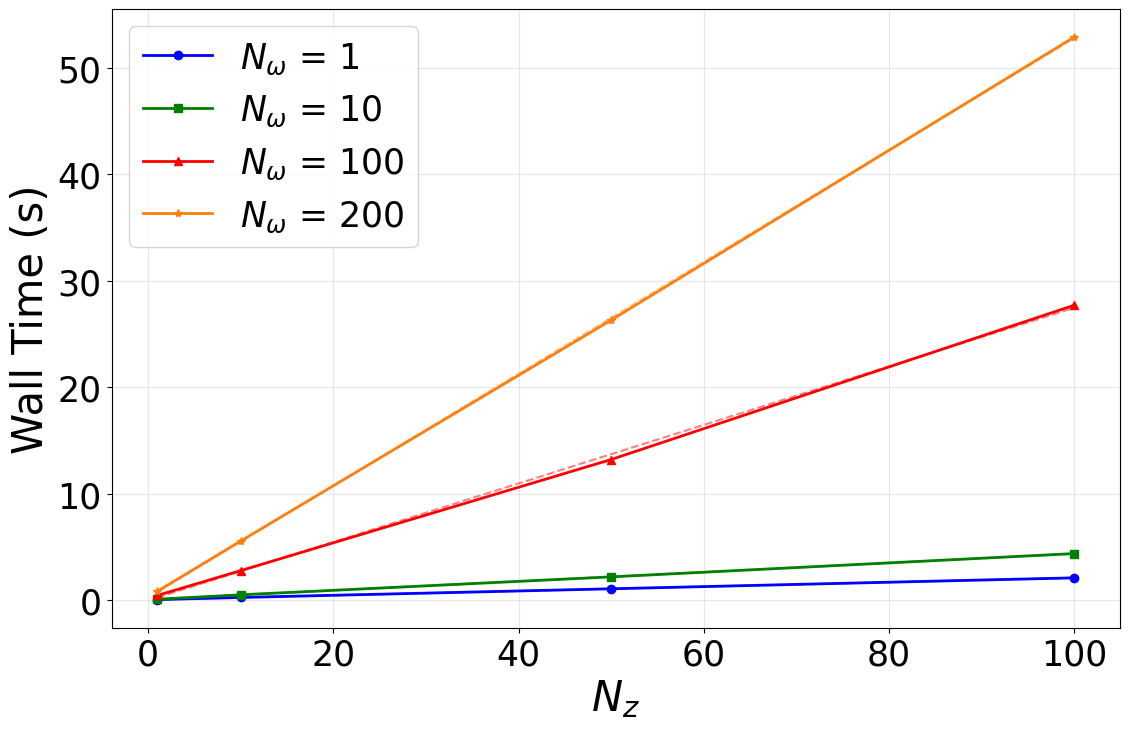

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io

# Parse the CSV data with constants
Nx = 500
Ny = 200

data = pd.read_csv(io.StringIO(csv_data))

# Define markers, colors, and workload values
workloads = [1, 10, 100, 200]
colors = ['blue', 'green', 'red', 'C1']
markers = ['o', 's', '^', '*']

# Create a combined plot on a single axis as well
plt.figure(figsize=(12, 8))

for i, workload in enumerate(workloads):
    # Filter data for this workload
    workload_data = data[data['Nw'] == workload]
    workload_data = workload_data.sort_values('Nz')
    
    # Plot the data
    plt.plot(workload_data['Nz'], workload_data['WallTime'], 
            marker=markers[i], color=colors[i], linewidth=2, 
            label=f'$N_\omega$ = {workload}')
    
    # Add a linear trend line
    z = np.polyfit(workload_data['Nz'], workload_data['WallTime'], 1)
    p = np.poly1d(z)
    x_trend = np.linspace(min(workload_data['Nz']), max(workload_data['Nz']), 100)
    plt.plot(x_trend, p(x_trend), '--', color=colors[i], alpha=0.5)

# Add labels and title
plt.xlabel('$N_z$')
plt.ylabel('Wall Time (s)')

# Add legend and grid
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()

# Save the combined plot
plt.savefig('prop_z_scaling.png', dpi=300, bbox_inches='tight')

plt.show()

In [49]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches

# Parse the data
data = pd.DataFrame({
    'ID': [48, 29, 28, 33, 34, 41, 27, 26, 32, 46, 40, 44, 45, 38, 16, 39, 35, 47, 17, 14, 37, 36, 22, 4, 15, 20, 24, 42, 2, 43, 25, 30, 23, 5, 21, 3, 10, 31, 12, 8, 11, 13, 18, 9, 0, 19, 1, 6, 7],
    'Duration': [1.96, 2.04, 2.09, 2.14, 2.14, 2.17, 2.21, 2.24, 2.26, 2.3, 2.3, 2.35, 2.38, 2.4, 2.46, 2.47, 2.54, 2.55, 2.66, 2.66, 2.77, 2.77, 2.9, 2.97, 3.05, 3.16, 3.25, 3.28, 3.31, 3.42, 3.64, 3.65, 4.25, 4.34, 4.79, 4.96, 5.28, 5.4, 5.4, 5.5, 7.66, 8.36, 8.6, 8.96, 9.15, 14.59, 15.11, 16.36, 28.12],
    'Compute Throughput': [46.02, 46.21, 48.08, 41.57, 46.88, 48.28, 40.86, 39.83, 39.53, 46.17, 53.44, 41.37, 40.08, 44.03, 35.81, 42.6, 37.25, 39.08, 32.47, 31.39, 31.55, 32.05, 30.34, 28.52, 27.78, 27.27, 25.24, 26.27, 25.14, 25.55, 22.75, 23.05, 20.43, 19.24, 17.53, 16.61, 15.84, 15.25, 14.96, 14.76, 10.91, 9.59, 9.36, 9.17, 8.67, 5.49, 5.25, 4.85, 2.83],
    'Memory Throughput': [59.97, 58.64, 56.45, 57.7, 55.23, 54.66, 54.92, 52.45, 53.1, 51.82, 51.12, 50.62, 50.13, 49.14, 48.3, 47.63, 47.24, 47.77, 44.22, 46.19, 48.14, 44.5, 40.5, 39.87, 39.7, 38.4, 40.2, 39.37, 36.63, 37.42, 35.76, 36.7, 27.59, 27.03, 24.55, 23.75, 22.09, 24.7, 24.36, 21.21, 15.34, 15.04, 15.4, 13.12, 14.45, 8.53, 8.67, 8.35, 4.71]
})

# Parse grid and block sizes
grid_sizes = []
block_sizes = []

grid_block_data = [
    ([8, 8, 4], [32, 16, 2]), ([16, 8, 4], [32, 4, 4]), ([16, 8, 4], [32, 16, 2]), 
    ([16, 8, 2], [16, 16, 2]), ([16, 8, 2], [32, 16, 2]), ([32, 16, 2], [32, 4, 4]), 
    ([16, 8, 4], [16, 16, 2]), ([16, 8, 4], [16, 16, 4]), ([16, 8, 2], [16, 16, 4]), 
    ([32, 4, 4], [32, 16, 2]), ([32, 16, 2], [32, 16, 2]), ([32, 4, 4], [16, 16, 4]), 
    ([32, 4, 4], [16, 16, 2]), ([32, 16, 2], [16, 16, 4]), ([8, 4, 4], [32, 16, 2]), 
    ([32, 16, 2], [16, 16, 2]), ([16, 8, 2], [32, 4, 4]), ([32, 4, 4], [32, 4, 4]), 
    ([8, 4, 4], [32, 4, 4]), ([8, 4, 4], [16, 16, 4]), ([32, 16, 2], [8, 8, 2]), 
    ([32, 16, 2], [8, 8, 4]), ([8, 4, 2], [32, 16, 2]), ([4, 4, 4], [32, 16, 2]), 
    ([8, 4, 4], [16, 16, 2]), ([8, 4, 2], [16, 16, 4]), ([16, 8, 4], [8, 8, 4]), 
    ([32, 4, 4], [8, 8, 4]), ([4, 4, 4], [16, 16, 4]), ([32, 4, 4], [8, 8, 2]), 
    ([16, 8, 4], [8, 8, 2]), ([16, 8, 2], [8, 8, 4]), ([8, 4, 2], [32, 4, 4]), 
    ([4, 4, 4], [32, 4, 4]), ([8, 4, 2], [16, 16, 2]), ([4, 4, 4], [16, 16, 2]), 
    ([4, 4, 2], [32, 16, 2]), ([16, 8, 2], [8, 8, 2]), ([8, 4, 4], [8, 8, 4]), 
    ([4, 4, 2], [16, 16, 4]), ([4, 4, 2], [32, 4, 4]), ([8, 4, 4], [8, 8, 2]), 
    ([8, 4, 2], [8, 8, 4]), ([4, 4, 2], [16, 16, 2]), ([4, 4, 4], [8, 8, 4]), 
    ([8, 4, 2], [8, 8, 2]), ([4, 4, 4], [8, 8, 2]), ([4, 4, 2], [8, 8, 4]), 
    ([4, 4, 2], [8, 8, 2])
]

for grid, block in grid_block_data:
    grid_sizes.append(grid)
    block_sizes.append(block)

data['Grid_Size_X'] = [int(g[0]) for g in grid_sizes]
data['Grid_Size_Y'] = [int(g[1]) for g in grid_sizes]
data['Grid_Size_Z'] = [int(g[2]) for g in grid_sizes]
data['Block_Size_X'] = [int(b[0]) for b in block_sizes]
data['Block_Size_Y'] = [int(b[1]) for b in block_sizes]
data['Block_Size_Z'] = [int(b[2]) for b in block_sizes]

# Calculate total threads and blocks
data['Total_Blocks'] = data['Grid_Size_X'] * data['Grid_Size_Y'] * data['Grid_Size_Z']
data['Threads_Per_Block'] = data['Block_Size_X'] * data['Block_Size_Y'] * data['Block_Size_Z']
data['Total_Threads'] = data['Total_Blocks'] * data['Threads_Per_Block']

# Function to determine text color based on background color
def get_text_color(val, vmin, vmax, is_lower_better=True):
    # Normalize value between 0 and 1
    norm_val = (val - vmin) / (vmax - vmin) if (vmax - vmin) > 0 else 0.5
    
    # For duration (lower is better), reverse the mapping
    if is_lower_better:
        norm_val = 1 - norm_val
    
    # Dark text for lighter backgrounds (< 0.5 on the colormap)
    # Light text for darker backgrounds (>= 0.5 on the colormap)
    return 'black' if norm_val > 0.5 else 'white'

# Create a function to generate heatmaps
def create_heatmap(data, metric, title, cmap, filename, vmin=None, vmax=None, is_lower_better=True):
    # Create a pivot table for the heatmap
    # If multiple values exist for a combination, take the best one
    if is_lower_better:
        agg_func = 'min'
        best_func = np.min
    else:
        agg_func = 'max'
        best_func = np.max
    
    pivot_data = data.pivot_table(
        values=metric,
        index='Total_Blocks', 
        columns='Threads_Per_Block',
        aggfunc=agg_func
    )
    
    # Find the best value and its position
    best_value = best_func(pivot_data.values[~np.isnan(pivot_data.values)])
    best_pos = None
    for i in range(len(pivot_data.index)):
        for j in range(len(pivot_data.columns)):
            if not np.isnan(pivot_data.iloc[i, j]) and pivot_data.iloc[i, j] == best_value:
                best_pos = (i, j)
                break
    
    # Create the figure
    plt.figure(figsize=(14, 10))
    ax = plt.gca()
    
    # Create the heatmap
    im = ax.imshow(pivot_data, cmap=cmap, aspect='auto', 
                  interpolation='nearest', vmin=vmin, vmax=vmax)
    
    # Add colorbar
    cbar = plt.colorbar(im)
    better_text = "Lower is Better" if is_lower_better else "Higher is Better"
    cbar.set_label(f"{metric} ({better_text})")
    
    # Set ticks and labels
    ax.set_xticks(np.arange(len(pivot_data.columns)))
    ax.set_yticks(np.arange(len(pivot_data.index)))
    ax.set_xticklabels(pivot_data.columns)
    ax.set_yticklabels(pivot_data.index)
    
    # Rotate the x-axis labels for better visibility
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Add text annotations in the heatmap cells with adaptive text color
    for i in range(len(pivot_data.index)):
        for j in range(len(pivot_data.columns)):
            if not np.isnan(pivot_data.iloc[i, j]):
                text_color = get_text_color(pivot_data.iloc[i, j], vmin, vmax, is_lower_better)
                
                # Add text
                text = ax.text(j, i, f"{pivot_data.iloc[i, j]:.2f}",
                              ha="center", va="center", color=text_color)
                
                # Highlight the best value
                if best_pos and i == best_pos[0] and j == best_pos[1]:
                    # Draw a rectangle around the best value
                    rect = patches.Rectangle((j-0.5, i-0.5), 1, 1, linewidth=3, 
                                           edgecolor='red', facecolor='none')
                    ax.add_patch(rect)
    
    # Add labels and title
    ax.set_xlabel("Threads Per Block")
    ax.set_ylabel("Total Blocks in Grid")
    # ax.set_title(title)
    
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.close()

# Create custom colormaps
duration_cmap = plt.cm.viridis_r  # Reversed (darker is better for duration)
compute_cmap = plt.cm.viridis     # Regular (brighter is better for throughput)
memory_cmap = plt.cm.viridis      # Regular (brighter is better for throughput)

# 1. Duration Heatmap (lower is better)
create_heatmap(
    data,
    'Duration',
    'Kernel Duration (ms) by Threads Per Block and Total Blocks',
    duration_cmap,
    'duration_heatmap.png',
    vmin=data['Duration'].min(),
    vmax=data['Duration'].max(),
    is_lower_better=True
)

# 2. Compute Throughput Heatmap (higher is better)
create_heatmap(
    data,
    'Compute Throughput',
    'Compute Throughput by Threads Per Block and Total Blocks',
    compute_cmap,
    'compute_heatmap.png',
    vmin=data['Compute Throughput'].min(),
    vmax=data['Compute Throughput'].max(),
    is_lower_better=False
)

# 3. Memory Throughput Heatmap (higher is better)
create_heatmap(
    data,
    'Memory Throughput',
    'Memory Throughput by Threads Per Block and Total Blocks',
    memory_cmap,
    'memory_heatmap.png',
    vmin=data['Memory Throughput'].min(),
    vmax=data['Memory Throughput'].max(),
    is_lower_better=False
)

# 4. Combined visualization showing the best configurations
# Calculate normalized scores
data['Norm_Duration'] = data['Duration'].min() / data['Duration']  # Invert so higher is better
data['Norm_Compute'] = data['Compute Throughput'] / data['Compute Throughput'].max()
data['Norm_Memory'] = data['Memory Throughput'] / data['Memory Throughput'].max()
data['Combined Score'] = (data['Norm_Duration'] + data['Norm_Compute'] + data['Norm_Memory']) / 3

# Create a combined score heatmap
create_heatmap(
    data,
    'Combined Score',
    'Combined Performance Score (Higher is Better)',
    plt.cm.viridis,
    'combined_score_heatmap.png',
    vmin=data['Combined Score'].min(),
    vmax=data['Combined Score'].max(),
    is_lower_better=False
)

#

In [51]:
Nx = 500
Ny = 200

csv_data = """
Nz,Nb,Nw,WallTime
1,1,100, 0.426
10,1,100, 2.76
50,1,100, 13.2
100,1,100, 27.7
1,2,100, 0.388
10,2,100, 2.45
50,2,100, 11.6
100,2,100, 22.8
1,5,100, 0.321
10,5,100, 2.29
50,5,100, 10.9
100,5,100, 21.5
1,10,100, 0.333
10,10,100, 2.45
50,10,100, 11.4
100,10,100, 22.9

"""

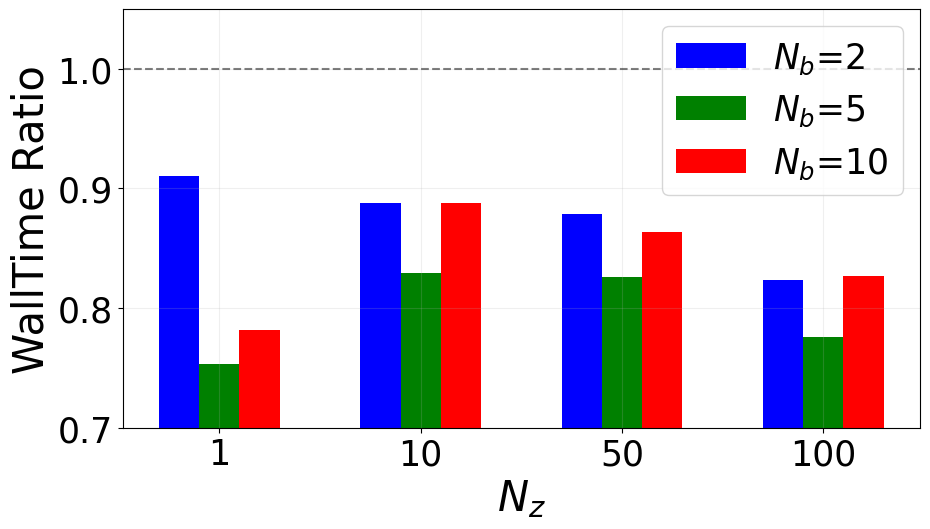

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io

# Parse the CSV data
data = pd.read_csv(io.StringIO(csv_data))

# Create a pivot table to make processing easier
pivot = data.pivot_table(index='Nz', columns='Nb', values='WallTime')

# Calculate the ratio of wall times compared to Nb=1
ratios = pivot.div(pivot[1], axis=0)

# Create the bar plot
plt.figure(figsize=(10, 6))

# Get unique values of Nz for x-axis and Nb for grouping
nz_values = sorted(data['Nz'].unique())
nb_values = sorted(data['Nb'].unique())[1:]  # Exclude Nb=1 since it's the baseline

# Set positions and width
x_positions = np.arange(len(nz_values))
width = 0.2  # Width of bars
colors = ['blue', 'green', 'red']

# Plot bars for each batch size
for i, nb in enumerate(nb_values):
    # Ensure all Nz values are included, using 1.0 for missing values (1.0 means same as baseline)
    heights = [ratios.loc[nz, nb] for nz in nz_values]
    
    position = x_positions + (i - len(nb_values)/2 + 0.5) * width
    plt.bar(position, heights, width, 
            label=f'$N_b$={nb}', 
            color=colors[i % len(colors)])

# Add labels and title
plt.xlabel('$N_z$')
plt.ylabel('WallTime Ratio')
plt.xticks(x_positions, nz_values)
plt.legend()

# Add a horizontal line at y=1 for reference (ratio = 1 means same performance as Nb=1)
plt.axhline(y=1, color='black', linestyle='--', alpha=0.5, label='Baseline ($N_b$=1)')

# Add grid lines
plt.grid(True, which="both", ls="-", alpha=0.2)

# Adjust limits to better show the ratio variations
plt.ylim(0.7, 1.05)

# Clean up
plt.tight_layout()

# Save the figure
plt.savefig('batch_size_ratios.png', dpi=300, bbox_inches='tight')

plt.show()